In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aeons.utils import *
from aeons.regress import *
from aeons.endpoint import *
from aeons.plotting import *
figsettings()

In [149]:
def get_beta(points, ndead):
    logX = points.logX().iloc[ndead]
    if logX < -points.D_KL():
        return 1
    def func(beta):
        return logX + points.set_beta(beta).D_KL()
    from scipy import optimize
    res = optimize.root_scalar(func, bracket=[0, 1])
    return res.root

def find_betadone(points, ndead, epsilon=1e-3):
    from scipy.special import logsumexp
    def func(beta):
        points_beta = points.set_beta(beta)
        logZdead = logsumexp(points_beta.logw().iloc[:ndead])
        logZlive = logsumexp(points_beta.logw().iloc[ndead:])
        return np.square(-np.log(epsilon) - np.log(1 + np.exp(logZdead - logZlive)))
    N = 100
    funcs = np.zeros(N)
    logbetas = np.linspace(-15, 0, 100)
    betas = np.exp(logbetas)
    for i, beta in enumerate(betas):
        funcs[i] = func(beta)
    grad = np.gradient(funcs)
    index = ((grad[1:] * grad[:-1]) < 0).nonzero()
    beta_done = betas[index]
    return beta_done

def get_dGs(samples, iterations, Nset=10):
    """Get the dG of the samples at each iteration"""
    iterations = iterations.astype(int)
    d_Gs = np.zeros(len(iterations))
    d_Gs_std = np.zeros(len(iterations))
    for i, iteration in enumerate(iterations):
        points = points_at_iteration(samples, iteration)
        beta = get_beta(points, iteration)
        points = points.set_beta(beta)
        d_Gs_i = points.d_G(Nset)
        d_Gs[i] = d_Gs_i.mean()
        d_Gs_std[i] = d_Gs_i.std()
        # Print progress bar
        print('\r', f'Iteration {iteration} of {iterations[-1]}, {d_Gs[i]}', end='')
    return d_Gs, d_Gs_std

def get_logXfs(model, method, iterations, Nset=25, epsilon=1e-3, **kwargs):
    """Method takes in arguments (ndead, logL, nk, logZdead, Nset, **kwargs) and returns logXfs_set"""
    N = len(iterations)
    logXfs = np.zeros(N)
    logXfs_std = np.zeros(N)
    for i, ndead in enumerate(iterations):
        logL, X_mean, nk, logZdead = model.data(ndead)
        try:
            logXfs_set, message = method(ndead, logL, nk, logZdead, Nset, **kwargs)
            logXfs[i] = np.mean(logXfs_set)
            logXfs_std[i] = np.std(logXfs_set)
            print('\r', f"Iteration {ndead} of {iterations[-1]}, {len(logXfs_set)} samples", end='')
        except:
            logXfs[i] = np.nan
            logXfs_std[i] = np.nan
            print('\r', f"Iteration {ndead} of {iterations[-1]}, model bad", end='')
    return logXfs, logXfs_std

In [2]:
name, samples = get_samples('toy', 'planck_gaussian')
model = EndModel(samples)
true_endpoint = model.true_endpoint()

(0.0, 9.638743381308995e-08)

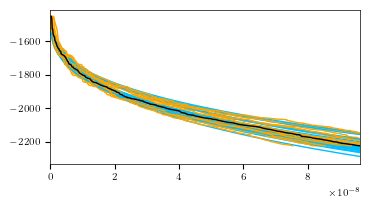

In [5]:
ndead = 10000
logL, X_mean, nk, logZdead = model.data(ndead)
points = points_at_iteration(samples, ndead)
beta = get_beta(points, ndead)
# beta = find_betadone(points, ndead)[0]
points = points.set_beta(beta)
d_Gs = points.d_G(25).values
Nset = 25
for j in range(Nset):
    X = generate_Xs(nk)
    # Pick a random element from the array of d_G
    d_G = d_Gs[np.random.randint(len(d_Gs))]
    theta = params_from_d(logL[ndead:], X[ndead:], d_G)
    plt.plot(X_mean[ndead:], full.func(X_mean[ndead:], theta), lw=1, color='deepskyblue')
    plt.plot(X[ndead:], logL[ndead:], lw=1, color='orange')
plt.plot(X_mean[ndead:], logL[ndead:], lw=1, color='black')
plt.xlim(0, X_mean[ndead])

## Model dimensionalities for different choices of $\beta^*$

In [29]:
def get_betastar(points, ndead, epsilon=1e-3):
    logX = points.logX()
    logL = points.logL
    def func(beta):
        logw = beta * logL + logX
        w = np.exp(logw - logw.max())
        Zdead = np.sum(w[:ndead])
        Zlive = np.sum(w[ndead:])
        return Zlive/Zdead - epsilon
    from scipy import optimize
    try:
        res = optimize.root_scalar(func, bracket=[0, 1])
        return res.root
    except:
        return 0

In [30]:
name, samples = get_samples('toy', 'gauss_16')
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = samples.logX().iloc[true_endpoint]

In [48]:
ndead = 10000
logL, X_mean, nk, logZdead = model.data(ndead)
points = points_at_iteration(samples, ndead).recompute()
logX = np.log(X_mean)

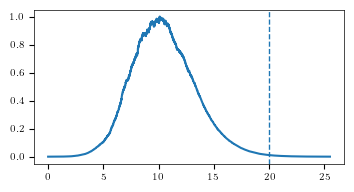

In [49]:
betastar = get_betastar(points, ndead)
logw = get_logw(logL, logX, betastar)
plt.plot(-logX, np.exp(logw - logw.max()))
plt.axvline(-logX[ndead], lw=1, ls='--')

In [50]:
iterations = make_iterations(true_endpoint, 25)
d_Gs = np.zeros(len(iterations))
d_Gs_std = np.zeros(len(iterations))
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    # beta = get_beta(points, ndead)
    betastar = get_betastar(points, ndead)
    points = points.set_beta(betastar)
    d_G = points.d_G(25).values
    d_Gs[i] = np.mean(d_G)
    d_Gs_std[i] = np.std(d_G)
    print('\r', f"Iteration {ndead} of {iterations[-1]}", end='')

/tmp/ipykernel_10640/3675075547.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 5147 of 30196

/tmp/ipykernel_10640/3675075547.py:9: RuntimeWarning: overflow encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 30196 of 30196

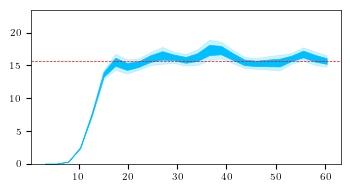

In [51]:
logXs = samples.logX().iloc[iterations]
plot_std(-logXs, d_Gs, d_Gs_std, d_Gs[-1], (0, 1.5))

In [63]:
points.set_beta(betastar).d_G()

13.82037743928887

## $\sigma(\beta)$
Requires a good estimate of true $\mathcal{D}_\mathrm{KL}$, which is not available (amounts to finding endpoint)

In [6]:
def logLmax_beta(d, sigma, X_i, logL_i):
    """Returns logLmax as a function of d and the live points at a certain iteration i"""
    n = len(X_i)
    logsum = np.sum(logL_i)
    sum_X_2d = np.sum(X_i**(2/d))
    return 1/n * logsum + 1/(2*n*sigma**2) * sum_X_2d

In [20]:
from aeons.toy_samples import gaussian_samples
samples = gaussian_samples(nlive=500, ndims=10, sigma=0.01, seed=0)

In [22]:
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = samples.logX().iloc[true_endpoint]

In [27]:
ndead = 5000
logL, X_mean, nk, logZdead = model.data(ndead)
points = points_at_iteration(samples, ndead)
beta = get_beta(points, ndead)
points = points.set_beta(beta)

DKL = points.D_KL()
d_G = points.d_G()
sigma_beta = np.sqrt(1/(2*np.pi*np.e) * np.exp(-2*DKL/d_G))
logLmax = logLmax_beta(d_G, sigma_beta, X_mean[ndead:], logL[ndead:])
theta_dG = params_from_d(logL[ndead:], X_mean[ndead:], d_G)
theta_beta = [logLmax, d_G, sigma_beta]
theta_beta

[-551.6611206408813, 10.365544886820137, 0.09228237841367827]

In [28]:
logXf_formula(theta_beta, logZdead, X_mean[ndead]), logXf_formula(theta_dG, logZdead, X_mean[ndead]), true_logXf

(-22.346618716906562, -45.086918928965275, -44.46554925779976)

## LCDM $\tilde{d}$

In [198]:
name, samples = get_samples('toy', 'cauchy_84')
model = EndModel(samples)
true_endpoint = model.true_endpoint()

In [199]:
ndead = 30000
logL, X_mean, nk, logZdead = model.data(ndead)
reg = GaussianRegress(logL[ndead:], X_mean[ndead:])

In [206]:
points = points_at_iteration(samples, ndead)
beta = get_beta(points, ndead)
d_G = points.set_beta(beta).d_G()

In [209]:
theta_dG = params_from_d(logL[ndead:], X_mean[ndead:], d_G)
theta = reg.theta

Gaussian prior for d

**Likelihood for d**

In [218]:
name, samples = get_samples('toy', 'gauss_16')
model = EndModel(samples)
ndead = 10000
points = points_at_iteration(samples, ndead)
logL, X_mean, nk, logZdead = model.data(ndead)
logLd, Xd = logL[ndead:], X_mean[ndead:]
N = len(logLd)
beta = get_beta(points, ndead)
dG = points.set_beta(beta).d_G(25).values
dG_mean = dG.mean()
dG_std = dG.std()

In [261]:
name, samples = get_samples('toy', 'gauss_16')
model = EndModel(samples)
true_endpoint = model.true_endpoint()

In [263]:
ndead = 25000
points = points_at_iteration(samples, ndead)
logL, X_mean, nk, logZdead = model.data(ndead)
logLd, Xd = logL[ndead:], X_mean[ndead:]
N = len(logLd)
beta = get_beta(points, ndead)
dG = points.set_beta(beta).d_G(25).values
dG_mean = dG.mean()
dG_std = dG.std()

In [264]:
def logprior(x, mu, sig):
    return -0.5*np.log(2*np.pi*sig**2) - np.power((x - mu)/sig, 2)/2

def loglike(d):
    """ Simple Gaussian Likelihood"""
    theta = params_from_d(logLd, Xd, d)
    loss = logLd - full.func(Xd, theta)
    L_sq = np.sum(loss**2)
    s = np.sqrt(L_sq/N)
    logPr = -1/2 * N * np.log(2*np.pi*s**2) - L_sq/(2*s**2)
    return logPr

In [265]:
ds = np.linspace(1, 70, 1000)
likes = np.zeros(len(ds))
for i, d in enumerate(ds):
    likes[i] = loglike(d)

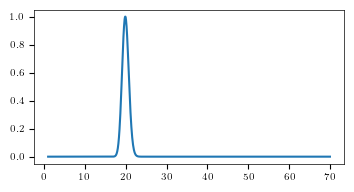

In [266]:
logpost = logprior(ds, dG_mean, dG_std) + likes
plt.plot(ds, np.exp(logpost - logpost.max()))